In [72]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import functional as TF

In [73]:
def nms(boxes, scores, iou_threshold=0.3):
    if len(boxes) == 0:
        return []

    # Ensure numpy arrays
    boxes = boxes.astype(float)
    scores = scores.astype(float)

    # Coordinates of bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute area of all boxes
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort by confidence score (highest first)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]  # index of highest score
        keep.append(i)

        # Compute IoU of the highest-score box with the rest
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # Compute intersection area
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        # IoU = intersection / (area1 + area2 - intersection)
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        # Keep boxes with IoU less than threshold
        inds = np.where(iou <= iou_threshold)[0]

        # Update order list
        order = order[inds + 1]

    return keep

In [74]:
device = 'cuda:3'

In [75]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(device)

/home/jupyter-st125842/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-st125842/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [76]:
img = cv2.imread('asm-1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = TF.to_tensor(img_rgb).to(device)
with torch.no_grad():
    preds = model([img_tensor])

preds = preds[0]
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()
scores = preds['scores'].cpu().numpy()
boxes = boxes[np.where(labels == 1)]
scores = scores[np.where(labels == 1)]
x1,y1,x2,y2 = boxes[nms(boxes,scores)].astype(np.int16)[0]
rect = (x1, y1, x2 - x1, y2 - y1)
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# --- Run GrabCut (1, 3, 5 iterations) ---
iterations = [1, 3, 5]
results = {}

for it in iterations:
    mask_it = mask.copy()
    cv2.grabCut(img, mask_it, rect, bgdModel, fgdModel, it, cv2.GC_INIT_WITH_RECT)
    mask_final = np.where((mask_it == cv2.GC_FGD) | (mask_it == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    results[it] = mask_final

In [77]:
def show_result(img, mask, title):
    fg = img * mask[:, :, np.newaxis]
    overlay = img.copy()
    overlay[mask == 1] = (0.6 * overlay[mask == 1] + 0.4 * np.array([0, 255, 0])).astype(np.uint8)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title(f"GrabCut Mask ({title})"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Overlay"); plt.axis("off")
    plt.show()
def mask_iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / union

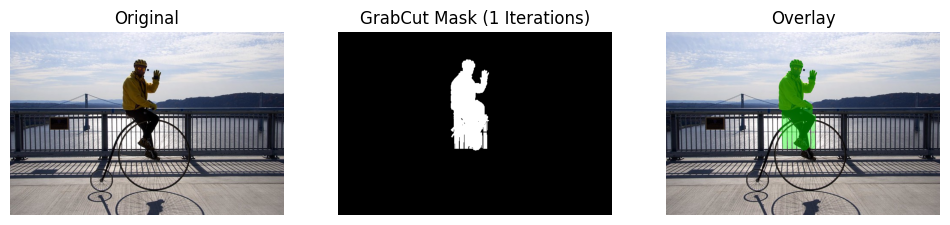

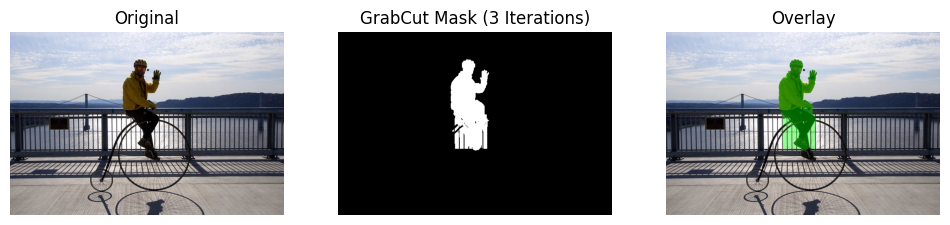

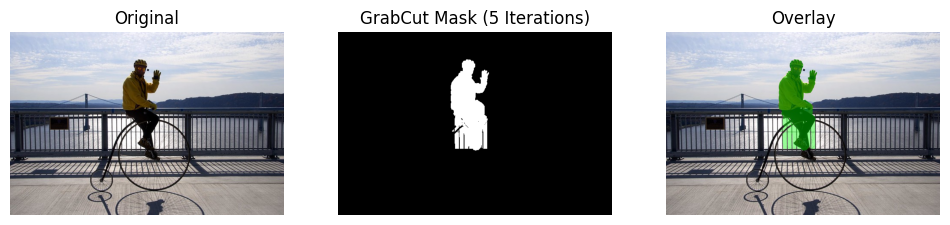

In [78]:
for it, mask in results.items():
    show_result(img, mask, f"{it} Iterations")

In [79]:
img = cv2.imread('asm-2.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = TF.to_tensor(img_rgb).to(device)
with torch.no_grad():
    preds = model([img_tensor])

preds = preds[0]
boxes = preds['boxes'].cpu().numpy()
labels = preds['labels'].cpu().numpy()
scores = preds['scores'].cpu().numpy()
boxes = boxes[np.where(labels == 1)]
scores = scores[np.where(labels == 1)]
x1,y1,x2,y2 = boxes[nms(boxes,scores)].astype(np.int16)[0]
rect = (x1, y1, x2 - x1, y2 - y1)
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# --- Run GrabCut (1, 3, 5 iterations) ---
iterations = [1, 3, 5]
results = {}

for it in iterations:
    mask_it = mask.copy()
    cv2.grabCut(img, mask_it, rect, bgdModel, fgdModel, it, cv2.GC_INIT_WITH_RECT)
    mask_final = np.where((mask_it == cv2.GC_FGD) | (mask_it == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    results[it] = mask_final

In [80]:
def show_result(img, mask, title):
    fg = img * mask[:, :, np.newaxis]
    overlay = img.copy()
    overlay[mask == 1] = (0.6 * overlay[mask == 1] + 0.4 * np.array([0, 255, 0])).astype(np.uint8)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title(f"GrabCut Mask ({title})"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title("Overlay"); plt.axis("off")
    plt.show()
def mask_iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / union

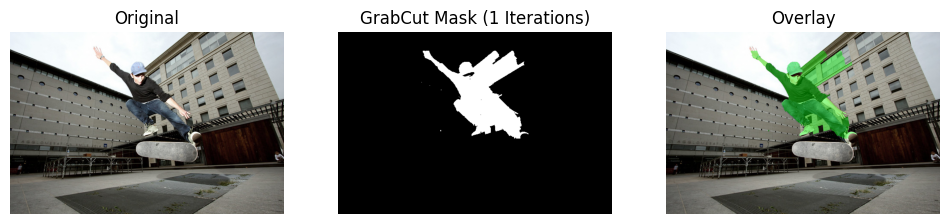

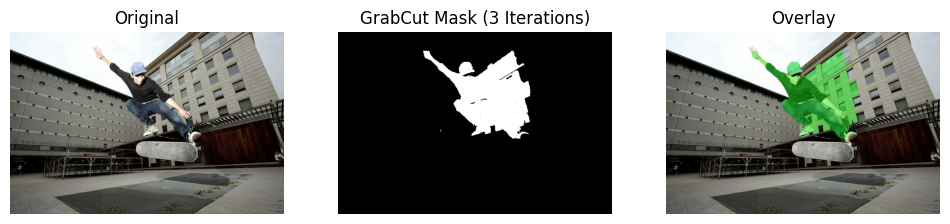

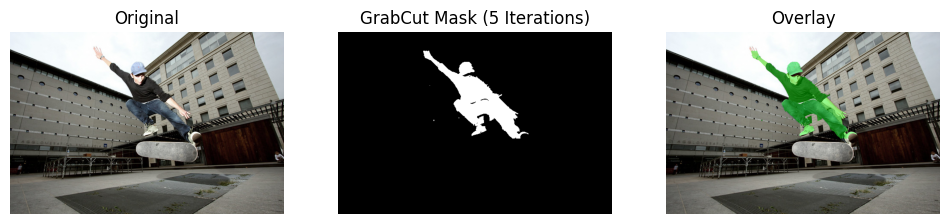

In [81]:
for it, mask in results.items():
    show_result(img, mask, f"{it} Iterations")